# ML Course 5 - Practice (correction)

## Subject

We will use here the same data set as for practice #3.

**`FuelConsumption.csv`** is a vehicle fuel consumption data set that contains model-specific fuel consumption.
-   **MODELYEAR** e.g. 2014
-   **MAKE** e.g. Acura
-   **MODEL** e.g. ILX
-   **VEHICLE CLASS** e.g. SUV
-   **ENGINE SIZE** e.g. 4.7
-   **CYLINDERS** e.g 6
-   **TRANSMISSION** e.g. A6
-   **FUEL CONSUMPTION in CITY(L/100 km)** e.g. 9.9
-   **FUEL CONSUMPTION in HWY (L/100 km)** e.g. 8.9
-   **FUEL CONSUMPTION COMB (L/100 km)** e.g. 9.2
-   **CO2 EMISSIONS (g/km)** e.g. 182   --> low --> 0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn 

In [4]:
data = pd.read_csv("Complexity 1/FuelConsumption.csv")

In [5]:
data.sample(6)

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
428,2014,FORD,TRANSIT CONNECT,SPECIAL PURPOSE VEHICLE,1.6,4,AS6,X,10.8,8.0,9.5,30,218
131,2014,BMW,X5 xDRIVE50i,SUV - STANDARD,4.4,8,A8,Z,16.3,10.9,13.9,20,320
1051,2014,VOLKSWAGEN,TIGUAN,SUV - SMALL,2.0,4,A6,Z,11.7,9.5,10.7,26,246
662,2014,LEXUS,IS 250,COMPACT,2.5,6,AS6,Z,11.2,7.8,9.7,29,223
832,2014,NISSAN,370Z,TWO-SEATER,3.7,6,AS7,Z,12.6,9.1,11.0,26,253
953,2014,SUBARU,IMPREZA WAGON AWD,STATION WAGON - SMALL,2.5,4,M5,Z,12.6,9.5,11.2,25,258


**Forward-Backward selection with all candidate predictors.**

## Proposition of correction for a Forward selection

In [36]:
data.nunique()

MODELYEAR                     1
MAKE                         39
MODEL                       663
VEHICLECLASS                 16
ENGINESIZE                   45
CYLINDERS                     7
TRANSMISSION                 22
FUELTYPE                      4
FUELCONSUMPTION_CITY        167
FUELCONSUMPTION_HWY         118
FUELCONSUMPTION_COMB        148
FUELCONSUMPTION_COMB_MPG     43
CO2EMISSIONS                159
dtype: int64

* Numeric features (ordered set): 'MODELYEAR', 'ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_CITY', 'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB', 'FUELCONSUMPTION_COMB_MPG'
* Non-numeric features: 'MAKE', 'MODEL', 'VEHICLECLASS', 'TRANSMISSION', 'FUELTYPE'
Even if we know that features are strongly correlated (fuel consumption features) and that 'MODELYEAR' has a unique value, we will consider all numeric features to check if the results match the intuition.
Concerning the non-numeric features, 'FUELTYPE' can take 4 differents values so we will encode it and consider it in the following. The other features take too many different values, we could encode it as well, but it would make too many features (possible to handle but more complex to understand). One other possibility could be to group values (feature engineering), e.g. the values of 'VEHICLECLASS' can be organized in three clusters little/middle/big cars.

For the sake of simplicity, we do not consider all non-numeric features here:

In [44]:
features = ['MODELYEAR', 'ENGINESIZE', 'CYLINDERS', 'FUELTYPE', 'FUELCONSUMPTION_CITY', 'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB', 'FUELCONSUMPTION_COMB_MPG']

# Data encoding
X = pd.get_dummies(data[features], columns=['FUELTYPE'], prefix=['FUELTYPE_is'])

y = data['CO2EMISSIONS'].values.reshape(-1,1)

X.sample(6)

,MODELYEAR,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,FUELTYPE_is_D,FUELTYPE_is_E,FUELTYPE_is_X,FUELTYPE_is_Z
503,2014,1.6,4,8.7,6.4,7.7,37,0,0,1,0
531,2014,3.7,6,13.6,9.3,11.7,24,0,0,0,1
324,2014,3.6,6,13.9,9.8,12.1,23,0,0,1,0
888,2014,3.4,6,11.3,7.9,9.8,29,0,0,0,1
326,2014,3.6,6,13.7,9.4,11.8,24,0,0,1,0
956,2014,2.5,4,11.3,8.2,9.9,29,0,0,1,0


In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

In [251]:
from sklearn.linear_model import LinearRegression

# We prepare our lists of features. The list features_in corresponds to 
# the selected features and one feature will be added at each step. The
# list features_out corresponds to the candidate features (not already
# selected) and one feature will be removed from this list at each step
# (the feature transfered to features_in).
features_in = []
features_out = X.columns.values.tolist()

# We prepare list to store the model scores each time a feature is added to the model.
rss_list = []
r2_list = []

# Loop on all the features. Based on the score they add to the model, there will be ordered
# in features_in based.
for i in range(len(X.columns)):
    
    print('==== Step ' + str(i+1) + ' ====================') 
        
    # Prepare a temporary dataframe for storing the scores
    score_list = pd.DataFrame(columns=['feature_candidate', 'rss', 'r2'])
    
    # Loop on feature candidates to check which one provide the most reduction on RSS.
    for feature_candidate in features_out:

        # Create dataframe of features to test
        features_in_test = features_in + [feature_candidate]
        # X_train_test = pd.concat([X_train[features_in], X_train[features_out]], axis=1)

        # Train regression
        reg = LinearRegression()
        reg.fit(X_train[features_in_test], y_train)
        y_pred = reg.predict(X_test[features_in_test])

        # Deduce performance
        rss = sum((y_pred - y_test) ** 2)[0]
        r2 = reg.score(X_test[features_in_test], y_test)
        print('    > Test with adding ' + feature_candidate + ': RSS = ' + str(int(rss)) + ', R2 = ' + str(round(r2,3)))

        # Store the results in a dataframe
        score_list = score_list.append({'feature_candidate': feature_candidate, 'rss': rss, 'r2': r2}, ignore_index=True)

    # We keep the feature_candidate giving the minimum score
    feature_selected = score_list['feature_candidate'][score_list['rss'].argmin()]
    features_in.append(feature_selected)
    features_out.remove(feature_selected)
    rss_selected = score_list['rss'].min()
    r2_selected = score_list['r2'][score_list['rss'].argmin()]
    rss_list.append(rss_selected)
    r2_list.append(r2_selected)
    print('=> We select ' + str(feature_selected) + ', features list is now ' + str(features_in), ' with RSS = ' + str(int(rss_selected)) + ', R2 = ' + str(round(r2_selected,3)) + '\n')


==== Step 1 ====================
    > Test with adding MODELYEAR: RSS = 1417024, R2 = -0.015
    > Test with adding ENGINESIZE: RSS = 373781, R2 = 0.732
    > Test with adding CYLINDERS: RSS = 421034, R2 = 0.699
    > Test with adding FUELCONSUMPTION_CITY: RSS = 299084, R2 = 0.786
    > Test with adding FUELCONSUMPTION_HWY: RSS = 375498, R2 = 0.731
    > Test with adding FUELCONSUMPTION_COMB: RSS = 309995, R2 = 0.778
    > Test with adding FUELCONSUMPTION_COMB_MPG: RSS = 281191, R2 = 0.799
    > Test with adding FUELTYPE_is_D: RSS = 1411012, R2 = -0.01
    > Test with adding FUELTYPE_is_E: RSS = 1375184, R2 = 0.015
    > Test with adding FUELTYPE_is_X: RSS = 1329330, R2 = 0.048
    > Test with adding FUELTYPE_is_Z: RSS = 1377875, R2 = 0.013
=> We select FUELCONSUMPTION_COMB_MPG, features list is now ['FUELCONSUMPTION_COMB_MPG']  with RSS = 281191, R2 = 0.799

==== Step 2 ====================
    > Test with adding MODELYEAR: RSS = 281191, R2 = 0.799
    > Test with adding ENGINESIZE: 

**Interpretation**:<br>
We have ordered the predictors in list features_in so to optimize the reduction of RSS. Let's now determine which number of predictors to keep. The other way to proceed it to set a threshold in the code above so to stop the loop once the RSS reduction is too small (e.g. less than 10 %).

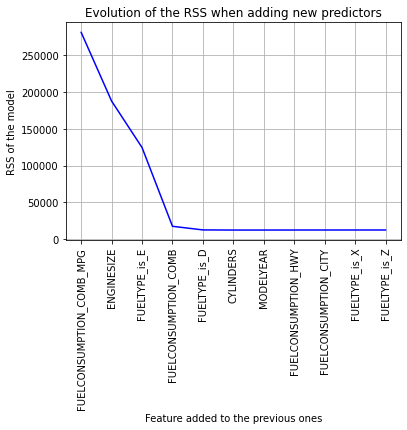

In [235]:
plt.figsize=(5,5)
plt.plot(features_in, rss_list, c='blue')
plt.xticks(rotation=90)
plt.xlabel('Feature added to the previous ones')
plt.ylabel('RSS of the model')
plt.title('Evolution of the RSS when adding new predictors')
plt.grid()
plt.show()

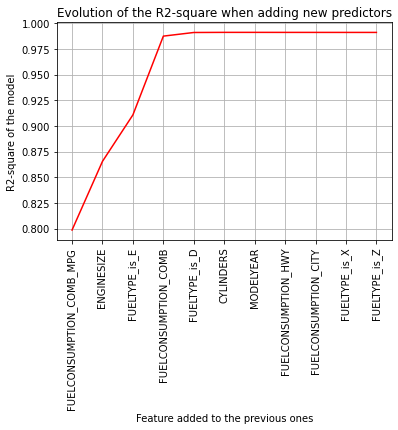

In [236]:
plt.figsize=(5,5)
plt.plot(features_in, r2_list, c='red')
plt.xticks(rotation=90)
plt.xlabel('Feature added to the previous ones')
plt.ylabel('R2-square of the model')
plt.title('Evolution of the R2-square when adding new predictors')
plt.grid()
plt.show()

We can apply here the "Elbow method" and these plots and keep the four first predictors of the ordered list features_in. If we add more predictors, the RSS reduction is then much less significant, probably because we have reached a floor due to dataset inherent error.

In [246]:
print(features_in[:4])

['FUELCONSUMPTION_COMB_MPG', 'ENGINESIZE', 'FUELTYPE_is_E', 'FUELCONSUMPTION_COMB']


Let's check the performance we get with these four predictors.

In [244]:
import statsmodels.api as sm
X_sm = sm.add_constant(X[features_in[:4]])
regressor = sm.OLS(y, X_sm).fit()
print(regressor.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 1.872e+04
Date:                Sun, 07 Feb 2021   Prob (F-statistic):               0.00
Time:                        17:56:42   Log-Likelihood:                -3662.6
No. Observations:                1067   AIC:                             7335.
Df Residuals:                    1062   BIC:                             7360.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   